In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [66]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy

In [297]:
#Double-layer seq2seq LSTM model
class LSTM_model():
    def __init__(self, feats_used, output_class):
        self.n_epochs = 2000
        self.batch_size = 512
        self.keep_rate = 0.5
        self.lr = 0.001
        self.feats_used = feats_used
        self.output_class = output_class
        
        self.hidden_dim = 512
        self.input_dim = len(feats_used)
        self.output_dim = 1
        self.input_seq_len = 10
        self.output_seq_len = 1
        self.num_stacked_layers = 2
        self.lambda_l2_reg = 0.003 
        self.GRADIENT_CLIPPING = 2.5
     
 
    def generate_train_samples(self, x, y, input_seq_len, output_seq_len, batch_size = 16):

        total_start_points = len(x) - input_seq_len - output_seq_len
        start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)

        input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
        input_seq = np.take(x, input_batch_idxs, axis = 0)

        output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
        output_seq = np.take(y, output_batch_idxs, axis = 0)

        return (input_seq, output_seq) # in shape: (batch_size, time_steps, feature_dim)

    def generate_test_samples(self, x, y, input_seq_len, output_seq_len):

        total_samples = x.shape[0]

        input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
        input_seq = np.take(x, input_batch_idxs, axis = 0)

        output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
        output_seq = np.take(y, output_batch_idxs, axis = 0)

        return (input_seq, output_seq)
    
    def get_data(self, paths):
            
        frames_X, frames_Y = [], []
        for path in paths:
            frames_X.append(pd.read_csv(path, usecols = self.feats_used))
            frames_Y.append(pd.read_csv(path, usecols = self.output_class))
        return (pd.concat(frames_X), pd.concat(frames_Y))
    
    
    def build_seq2seq_model(self, feed_previous = False):
 
        global_step = tf.Variable(
                      initial_value=0,
                      name="global_step",
                      trainable=False,
                      collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])

        weights = {
            'out': tf.get_variable('Weights_out', \
                                   shape = [self.hidden_dim, self.output_dim], \
                                   dtype = tf.float32, \
                                   initializer = tf.contrib.layers.xavier_initializer())
        }
        biases = {
            'out': tf.get_variable('Biases_out', \
                                   shape = [self.output_dim], \
                                   dtype = tf.float32, \
                                   initializer = tf.zeros_initializer())
        }
 
        with tf.variable_scope('Seq2seq'):
            # Encoder: inputs
            enc_inp = [
                tf.placeholder(tf.float32, shape=(None, self.input_dim), name="inp_{}".format(t))
                   for t in range(self.input_seq_len)
            ]

            # Decoder: target outputs
            target_seq = [
                tf.placeholder(tf.float32, shape=(None, self.output_dim), name="y".format(t))
                  for t in range(self.output_seq_len)
            ]

            # Give a "GO" token to the decoder.
            # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the
            # first element will be fed as decoder input which is then 'un-guided'
            dec_inp = [tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO")] + target_seq[:-1]

            with tf.variable_scope('LSTMCell'):
                cells = []
                for i in range(self.num_stacked_layers):
                    with tf.variable_scope('RNN_{}'.format(i)):
                        cells.append(tf.contrib.rnn.LSTMCell(self.hidden_dim))
                cell = tf.contrib.rnn.MultiRNNCell(cells)

            def _rnn_decoder(decoder_inputs,
                            initial_state,
                            cell,
                            loop_function=None,
                            scope=None):
                """RNN decoder for the sequence-to-sequence model.
                Args:
                decoder_inputs: A list of 2D Tensors [batch_size x input_size].
                initial_state: 2D Tensor with shape [batch_size x cell.state_size].
                cell: rnn_cell.RNNCell defining the cell function and size.
                loop_function: If not None, this function will be applied to the i-th output
                  in order to generate the i+1-st input, and decoder_inputs will be ignored,
                  except for the first element ("GO" symbol). This can be used for decoding,
                  but also for training to emulate http://arxiv.org/abs/1506.03099.
                  Signature -- loop_function(prev, i) = next
                    * prev is a 2D Tensor of shape [batch_size x output_size],
                    * i is an integer, the step number (when advanced control is needed),
                    * next is a 2D Tensor of shape [batch_size x input_size].
                scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
                Returns:
                A tuple of the form (outputs, state), where:
                  outputs: A list of the same length as decoder_inputs of 2D Tensors with
                    shape [batch_size x output_size] containing generated outputs.
                  state: The state of each cell at the final time-step.
                    It is a 2D Tensor of shape [batch_size x cell.state_size].
                    (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                     states can be the same. They are different for LSTM cells though.)
                """
                with variable_scope.variable_scope(scope or "rnn_decoder"):
                    state = initial_state
                    outputs = []
                    prev = None
                    for i, inp in enumerate(decoder_inputs):
                        if loop_function is not None and prev is not None:
                            with variable_scope.variable_scope("loop_function", reuse=True):
                                inp = loop_function(prev, i)
                        if i > 0:
                            variable_scope.get_variable_scope().reuse_variables()
                        output, state = cell(inp, state)
                        outputs.append(output)
                        if loop_function is not None:
                            prev = output
                return (outputs, state)

            def _basic_rnn_seq2seq(encoder_inputs,
                                  decoder_inputs,
                                  cell,
                                  feed_prev,
                                  dtype=dtypes.float32,
                                  scope=None):
                """Basic RNN sequence-to-sequence model.
                This model first runs an RNN to encode encoder_inputs into a state vector,
                then runs decoder, initialized with the last encoder state, on decoder_inputs.
                Encoder and decoder use the same RNN cell type, but don't share parameters.
                Args:
                encoder_inputs: A list of 2D Tensors [batch_size x input_size].
                decoder_inputs: A list of 2D Tensors [batch_size x input_size].
                feed_previous: Boolean; if True, only the first of decoder_inputs will be
                  used (the "GO" symbol), all other inputs will be generated by the previous
                  decoder output using _loop_function below. If False, decoder_inputs are used
                  as given (the standard decoder case).
                dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
                scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
                Returns:
                A tuple of the form (outputs, state), where:
                  outputs: A list of the same length as decoder_inputs of 2D Tensors with
                    shape [batch_size x output_size] containing the generated outputs.
                  state: The state of each decoder cell in the final time-step.
                    It is a 2D Tensor of shape [batch_size x cell.state_size].
                """
                with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                    enc_cell = copy.deepcopy(cell)
                    _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                    if feed_prev:
                        return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
                    else:
                        return _rnn_decoder(decoder_inputs, enc_state, cell)

            def _loop_function(prev, _):
                '''Naive implementation of loop function for _rnn_decoder. Transform prev from
                dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
                used as decoder input of next time step '''
                return tf.matmul(prev, weights['out']) + biases['out']

            dec_outputs, dec_memory = _basic_rnn_seq2seq(
                enc_inp,
                dec_inp,
                cell,
                feed_prev = feed_previous
            )
            #print(dec_outputs)
            reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]

        # Training loss and optimizer
        with tf.variable_scope('Loss'):
            # L2 loss
            output_loss = 0
            for _y, _Y in zip(reshaped_outputs, target_seq):
                output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

            # L2 regularization for weights and biases
            reg_loss = 0
            for tf_var in tf.trainable_variables():
                if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                    reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

            loss = output_loss + lambda_l2_reg * reg_loss
        with tf.variable_scope('Optimizer'):
            optimizer = tf.contrib.layers.optimize_loss(
                    loss = loss,
                    learning_rate=self.lr,
                    global_step = global_step,
                    optimizer='Adam',
                    clip_gradients=self.GRADIENT_CLIPPING)

        saver = tf.train.Saver
 
        return dict(
            enc_inp = enc_inp,
            target_seq = target_seq,
            train_op = optimizer,
            loss=loss,
            saver = saver,
            reshaped_outputs = reshaped_outputs,
            )

    def train(self, sess, train_paths):
        X, Y = self.get_data(train_paths) #All train data in one series
        X_train, Y_train = X.values, Y.values
        
        train_losses = []

        rnn_model = self.build_seq2seq_model(feed_previous=False)


        train_preds, train_targets = [], []

        sess.run(tf.global_variables_initializer())

        try:
            print("Training initiated...")
            for i in range(self.n_epochs): #1 iteration per epoch
                batch_input, batch_output = generate_train_samples(X_train, Y_train, 
                                                                   self.input_seq_len, self.output_seq_len,
                                                                   batch_size=self.batch_size)
                feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(self.input_seq_len)}
                feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(self.output_seq_len)})
                _, loss_t, reshaped_outputs, target_seq = sess.run([rnn_model['train_op'], rnn_model['loss'],
                                                               rnn_model['reshaped_outputs'], rnn_model['target_seq']],
                                                              feed_dict)
                print("Training iterations: {}, Loss: {}".format(i+1, loss_t))
                if (i % 10 == 0) : 
                    train_losses.append(loss_t)
                    for i in range(len(target_seq)):
                        train_preds.append(reshaped_outputs[i]) 
                        train_targets.append(target_seq[i]) 
        except KeyboardInterrupt:
            print("Training interrupted.")

        temp_saver = rnn_model['saver']()
        save_path = temp_saver.save(sess, os.path.join('./saved_model/', 'multivariate_ts_pollution_case'))
        #plt.plot(train_losses) 
        
        print("Checkpoint saved at: ", save_path)
        train_targets = [tar[0][0] for tar in train_targets]
        train_preds = [tar[0][0] for tar in train_preds]
        return (train_preds, train_targets, train_losses)
    
    def test(self, sess, test_paths):
        print("Started testing...")
        rnn_model = self.build_seq2seq_model(feed_previous=True)

        X, Y = get_data(test_paths) #All test data in one series
        X_test, Y_test = X.values, Y.values
        test_x, test_y = generate_test_samples(X_test, Y_test, input_seq_len, output_seq_len)

        sess.run(tf.global_variables_initializer())

        saver = rnn_model['saver']().restore(sess,  os.path.join('./saved_model/', 'multivariate_ts_pollution_case'))

        feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(self.input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], self.output_dim], dtype=np.float32) for t in range(self.output_seq_len)})
        final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)

        final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
        final_preds = np.concatenate(final_preds, axis = 1)
        
        final_preds = final_preds[:, 0, 0]
        test_y = test_y[:, 0, 0]
        
        MSE_loss = np.mean((final_preds - test_y)**2)
        print("Test mse is: ", MSE_loss)
        return (final_preds, test_y, MSE_loss)


Training iterations: 1, Loss: 21995.837890625
Training iterations: 2, Loss: 18357.61328125
Training iterations: 3, Loss: 18239.947265625
Training iterations: 4, Loss: 14897.3359375
Training iterations: 5, Loss: 14366.828125
Training iterations: 6, Loss: 16509.86328125
Training interrupted.
Checkpoint saved at:  ./saved_model/multivariate_ts_pollution_case


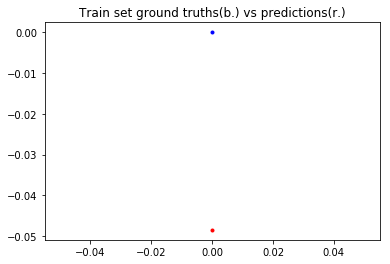

INFO:tensorflow:Restoring parameters from ./saved_model/multivariate_ts_pollution_case
Test mse is:  17618.542567208304


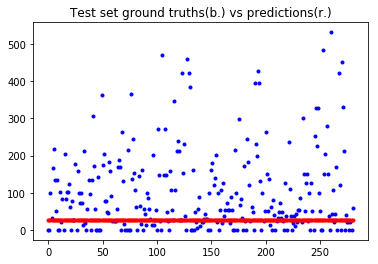

In [296]:
train_ds = ["CS107Autumn2017dataset.csv", "CS107Autumn2018dataset.csv", "CS107Spring2017dataset.csv", "CS107Spring2018dataset.csv", ]
test_ds = ["CS107Winter2018dataset.csv"]
dir_path = "DeepQueueLearning/Datasets/"
feats_used = ["day", "hourOfDay", "weekNum", "daysAfterPrevAssnDue", "daysUntilNextAssnDue", "daysTilExam", 
                         "isFirstOHWithinLastThreeHour", "NumStudents", "InstructorRating", "AvgHrsSpent"]
output_class = ["loadInflux"]

train_paths, test_paths = [], []
for ds in train_ds:
    train_paths.append(dir_path + ds)
for ds in test_ds:
    test_paths.append(dir_path + ds)
    
sys_model = LSTM_model(feats_used, output_class)
#Train time
tf.reset_default_graph()

with tf.Session() as sess:
    train_preds, train_targets, train_losses = sys_model.train(sess, train_paths)

plt.plot(range(len(train_targets)), train_targets, 'b.', range(len(train_preds)), train_preds, 'r.')
plt.title("Train set ground truths(b.) vs predictions(r.)")
plt.show()

tf.reset_default_graph()
with tf.Session() as sess:
    final_preds, test_y, test_loss = sys_model.test(sess, test_paths)

plt.plot(range(len(test_y)), test_y, 'b.', range(len(test_y)), final_preds, 'r.')
plt.title("Test set ground truths(b.) vs predictions(r.)")
plt.show()

Training losses: 
(512, 10, 10)
Training iteration: 1, Loss: 18207.099609375
(512, 10, 10)
Training iteration: 2, Loss: 14612.6728515625
(512, 10, 10)
Training iteration: 3, Loss: 14338.38671875
(512, 10, 10)
Training iteration: 4, Loss: 14200.4658203125
(512, 10, 10)
Training iteration: 5, Loss: 9500.6259765625
(512, 10, 10)
Training iteration: 6, Loss: 12005.423828125
(512, 10, 10)
Training iteration: 7, Loss: 16621.232421875
(512, 10, 10)
Training iteration: 8, Loss: 15226.7685546875
(512, 10, 10)
Training iteration: 9, Loss: 9258.58984375
(512, 10, 10)
Training iteration: 10, Loss: 11595.7529296875
(512, 10, 10)
Training iteration: 11, Loss: 11642.6787109375
(512, 10, 10)
Training iteration: 12, Loss: 16970.052734375
(512, 10, 10)
Training iteration: 13, Loss: 15402.392578125
(512, 10, 10)
Training iteration: 14, Loss: 11500.0419921875
(512, 10, 10)
Training iteration: 15, Loss: 10138.9990234375
(512, 10, 10)
Training iteration: 16, Loss: 9115.6533203125
(512, 10, 10)
Training iter

Training iteration: 138, Loss: 13925.4990234375
(512, 10, 10)
Training iteration: 139, Loss: 10086.3330078125
(512, 10, 10)
Training iteration: 140, Loss: 11535.8466796875
(512, 10, 10)
Training iteration: 141, Loss: 10810.9541015625
(512, 10, 10)
Training iteration: 142, Loss: 12977.9638671875
(512, 10, 10)
Training iteration: 143, Loss: 12286.3173828125
(512, 10, 10)
Training iteration: 144, Loss: 10984.8583984375
(512, 10, 10)
Training iteration: 145, Loss: 11394.3232421875
(512, 10, 10)
Training iteration: 146, Loss: 13780.59375
(512, 10, 10)
Training iteration: 147, Loss: 12740.294921875
(512, 10, 10)
Training iteration: 148, Loss: 12728.8193359375
(512, 10, 10)
Training iteration: 149, Loss: 14038.9365234375
(512, 10, 10)
Training iteration: 150, Loss: 12169.859375
(512, 10, 10)
Training iteration: 151, Loss: 8219.3681640625
(512, 10, 10)
Training iteration: 152, Loss: 12451.6953125
(512, 10, 10)
Training iteration: 153, Loss: 12970.208984375
(512, 10, 10)
Training iteration: 154

Training iteration: 273, Loss: 9804.6005859375
(512, 10, 10)
Training iteration: 274, Loss: 11894.45703125
(512, 10, 10)
Training iteration: 275, Loss: 13028.5537109375
(512, 10, 10)
Training iteration: 276, Loss: 12992.685546875
(512, 10, 10)
Training iteration: 277, Loss: 10077.357421875
(512, 10, 10)
Training iteration: 278, Loss: 9320.7275390625
(512, 10, 10)
Training iteration: 279, Loss: 12320.375
(512, 10, 10)
Training iteration: 280, Loss: 11297.69921875
(512, 10, 10)
Training iteration: 281, Loss: 8655.380859375
(512, 10, 10)
Training iteration: 282, Loss: 12361.220703125
(512, 10, 10)
Training iteration: 283, Loss: 13307.9990234375
(512, 10, 10)
Training iteration: 284, Loss: 12446.9267578125
(512, 10, 10)
Training iteration: 285, Loss: 14220.3203125
(512, 10, 10)
Training iteration: 286, Loss: 11640.0107421875
(512, 10, 10)
Training iteration: 287, Loss: 11514.7470703125
(512, 10, 10)
Training iteration: 288, Loss: 13007.73828125
(512, 10, 10)
Training iteration: 289, Loss: 

Training iteration: 408, Loss: 11495.5380859375
(512, 10, 10)
Training iteration: 409, Loss: 12562.359375
(512, 10, 10)
Training iteration: 410, Loss: 9231.396484375
(512, 10, 10)
Training iteration: 411, Loss: 11405.419921875
(512, 10, 10)
Training iteration: 412, Loss: 13578.4716796875
(512, 10, 10)
Training iteration: 413, Loss: 11900.0712890625
(512, 10, 10)
Training iteration: 414, Loss: 10918.208984375
(512, 10, 10)
Training iteration: 415, Loss: 11522.6396484375
(512, 10, 10)
Training iteration: 416, Loss: 9914.16796875
(512, 10, 10)
Training iteration: 417, Loss: 9122.685546875
(512, 10, 10)
Training iteration: 418, Loss: 13013.66015625
(512, 10, 10)
Training iteration: 419, Loss: 13897.8125
(512, 10, 10)
Training iteration: 420, Loss: 9433.15234375
(512, 10, 10)
Training iteration: 421, Loss: 12750.6416015625
(512, 10, 10)
Training iteration: 422, Loss: 8571.3212890625
(512, 10, 10)
Training iteration: 423, Loss: 12728.541015625
(512, 10, 10)
Training iteration: 424, Loss: 100

Training iteration: 544, Loss: 13723.0126953125
(512, 10, 10)
Training iteration: 545, Loss: 7501.59326171875
(512, 10, 10)
Training iteration: 546, Loss: 11095.9228515625
(512, 10, 10)
Training iteration: 547, Loss: 11540.0068359375
(512, 10, 10)
Training iteration: 548, Loss: 8963.9541015625
(512, 10, 10)
Training iteration: 549, Loss: 8777.6982421875
(512, 10, 10)
Training iteration: 550, Loss: 9797.2822265625
(512, 10, 10)
Training iteration: 551, Loss: 12108.2099609375
(512, 10, 10)
Training iteration: 552, Loss: 12378.4423828125
(512, 10, 10)
Training iteration: 553, Loss: 10021.8759765625
(512, 10, 10)
Training iteration: 554, Loss: 11564.9794921875
(512, 10, 10)
Training iteration: 555, Loss: 13662.4638671875
(512, 10, 10)
Training iteration: 556, Loss: 11049.8994140625
(512, 10, 10)
Training iteration: 557, Loss: 10479.240234375
(512, 10, 10)
Training iteration: 558, Loss: 6439.12841796875
(512, 10, 10)
Training iteration: 559, Loss: 9972.146484375
(512, 10, 10)
Training itera

Training iteration: 679, Loss: 8158.60693359375
(512, 10, 10)
Training iteration: 680, Loss: 10749.646484375
(512, 10, 10)
Training iteration: 681, Loss: 8713.4765625
(512, 10, 10)
Training iteration: 682, Loss: 10138.7919921875
(512, 10, 10)
Training iteration: 683, Loss: 6203.82177734375
(512, 10, 10)
Training iteration: 684, Loss: 6244.33837890625
(512, 10, 10)
Training iteration: 685, Loss: 10018.13671875
(512, 10, 10)
Training iteration: 686, Loss: 7587.66650390625
(512, 10, 10)
Training iteration: 687, Loss: 9059.296875
(512, 10, 10)
Training iteration: 688, Loss: 7352.94873046875
(512, 10, 10)
Training iteration: 689, Loss: 10360.779296875
(512, 10, 10)
Training iteration: 690, Loss: 10287.232421875
(512, 10, 10)
Training iteration: 691, Loss: 8096.9521484375
(512, 10, 10)
Training iteration: 692, Loss: 6976.8623046875
(512, 10, 10)
Training iteration: 693, Loss: 9669.89453125
(512, 10, 10)
Training iteration: 694, Loss: 7475.39404296875
(512, 10, 10)
Training iteration: 695, Lo

Training iteration: 814, Loss: 8708.515625
(512, 10, 10)
Training iteration: 815, Loss: 6666.60498046875
(512, 10, 10)
Training iteration: 816, Loss: 9988.8603515625
(512, 10, 10)
Training iteration: 817, Loss: 8988.7724609375
(512, 10, 10)
Training iteration: 818, Loss: 5787.8017578125
(512, 10, 10)
Training iteration: 819, Loss: 7998.94287109375
(512, 10, 10)
Training iteration: 820, Loss: 9489.162109375
(512, 10, 10)
Training iteration: 821, Loss: 8395.8193359375
(512, 10, 10)
Training iteration: 822, Loss: 6710.17822265625
(512, 10, 10)
Training iteration: 823, Loss: 4697.9736328125
(512, 10, 10)
Training iteration: 824, Loss: 8381.783203125
(512, 10, 10)
Training iteration: 825, Loss: 8772.3095703125
(512, 10, 10)
Training iteration: 826, Loss: 8312.1953125
(512, 10, 10)
Training iteration: 827, Loss: 8191.3046875
(512, 10, 10)
Training iteration: 828, Loss: 8637.6259765625
(512, 10, 10)
Training iteration: 829, Loss: 9295.2685546875
(512, 10, 10)
Training iteration: 830, Loss: 80

Training iteration: 950, Loss: 7085.94921875
(512, 10, 10)
Training iteration: 951, Loss: 6969.8125
(512, 10, 10)
Training iteration: 952, Loss: 7757.89990234375
(512, 10, 10)
Training iteration: 953, Loss: 5126.50537109375
(512, 10, 10)
Training iteration: 954, Loss: 7287.40283203125
(512, 10, 10)
Training iteration: 955, Loss: 8070.04931640625
(512, 10, 10)
Training iteration: 956, Loss: 7349.51318359375
(512, 10, 10)
Training iteration: 957, Loss: 7064.88671875
(512, 10, 10)
Training iteration: 958, Loss: 5826.0791015625
(512, 10, 10)
Training iteration: 959, Loss: 5824.59521484375
(512, 10, 10)
Training iteration: 960, Loss: 6371.59375
(512, 10, 10)
Training iteration: 961, Loss: 6037.21533203125
(512, 10, 10)
Training iteration: 962, Loss: 5478.6748046875
(512, 10, 10)
Training iteration: 963, Loss: 5220.0048828125
(512, 10, 10)
Training iteration: 964, Loss: 4425.36328125
(512, 10, 10)
Training iteration: 965, Loss: 4861.2939453125
(512, 10, 10)
Training iteration: 966, Loss: 792

Training iteration: 1083, Loss: 4419.9267578125
(512, 10, 10)
Training iteration: 1084, Loss: 4834.73681640625
(512, 10, 10)
Training iteration: 1085, Loss: 5363.0556640625
(512, 10, 10)
Training iteration: 1086, Loss: 4012.2939453125
(512, 10, 10)
Training iteration: 1087, Loss: 4568.2109375
(512, 10, 10)
Training iteration: 1088, Loss: 4602.92138671875
(512, 10, 10)
Training iteration: 1089, Loss: 5700.0380859375
(512, 10, 10)
Training iteration: 1090, Loss: 6329.16552734375
(512, 10, 10)
Training iteration: 1091, Loss: 3752.73583984375
(512, 10, 10)
Training iteration: 1092, Loss: 4635.2724609375
(512, 10, 10)
Training iteration: 1093, Loss: 6116.25732421875
(512, 10, 10)
Training iteration: 1094, Loss: 4764.65283203125
(512, 10, 10)
Training iteration: 1095, Loss: 3865.64697265625
(512, 10, 10)
Training iteration: 1096, Loss: 4349.478515625
(512, 10, 10)
Training iteration: 1097, Loss: 4402.5546875
(512, 10, 10)
Training iteration: 1098, Loss: 4792.6318359375
(512, 10, 10)
Training

Training iteration: 1215, Loss: 4029.019287109375
(512, 10, 10)
Training iteration: 1216, Loss: 4210.88720703125
(512, 10, 10)
Training iteration: 1217, Loss: 3523.2978515625
(512, 10, 10)
Training iteration: 1218, Loss: 2711.56005859375
(512, 10, 10)
Training iteration: 1219, Loss: 4535.0078125
(512, 10, 10)
Training iteration: 1220, Loss: 5429.87841796875
(512, 10, 10)
Training iteration: 1221, Loss: 3538.6875
(512, 10, 10)
Training iteration: 1222, Loss: 4672.0458984375
(512, 10, 10)
Training iteration: 1223, Loss: 2640.638427734375
(512, 10, 10)
Training iteration: 1224, Loss: 5214.1484375
(512, 10, 10)
Training iteration: 1225, Loss: 2746.455078125
(512, 10, 10)
Training iteration: 1226, Loss: 5351.01025390625
(512, 10, 10)
Training iteration: 1227, Loss: 5287.78125
(512, 10, 10)
Training iteration: 1228, Loss: 3528.873291015625
(512, 10, 10)
Training iteration: 1229, Loss: 2914.00634765625
(512, 10, 10)
Training iteration: 1230, Loss: 4954.15185546875
(512, 10, 10)
Training itera

Training iteration: 1347, Loss: 1839.3577880859375
(512, 10, 10)
Training iteration: 1348, Loss: 3415.411865234375
(512, 10, 10)
Training iteration: 1349, Loss: 3264.4619140625
(512, 10, 10)
Training iteration: 1350, Loss: 4490.7900390625
(512, 10, 10)
Training iteration: 1351, Loss: 2039.263427734375
(512, 10, 10)
Training iteration: 1352, Loss: 2804.33642578125
(512, 10, 10)
Training iteration: 1353, Loss: 3148.27294921875
(512, 10, 10)
Training iteration: 1354, Loss: 2593.236572265625
(512, 10, 10)
Training iteration: 1355, Loss: 2886.76806640625
(512, 10, 10)
Training iteration: 1356, Loss: 5339.7529296875
(512, 10, 10)
Training iteration: 1357, Loss: 4132.61962890625
(512, 10, 10)
Training iteration: 1358, Loss: 3755.778564453125
(512, 10, 10)
Training iteration: 1359, Loss: 4835.5263671875
(512, 10, 10)
Training iteration: 1360, Loss: 2955.75830078125
(512, 10, 10)
Training iteration: 1361, Loss: 2570.820556640625
(512, 10, 10)
Training iteration: 1362, Loss: 3969.6923828125
(512

Training iteration: 1477, Loss: 3632.1435546875
(512, 10, 10)
Training iteration: 1478, Loss: 1962.2734375
(512, 10, 10)
Training iteration: 1479, Loss: 3101.506103515625
(512, 10, 10)
Training iteration: 1480, Loss: 1641.158447265625
(512, 10, 10)
Training iteration: 1481, Loss: 3016.0087890625
(512, 10, 10)
Training iteration: 1482, Loss: 1928.1221923828125
(512, 10, 10)
Training iteration: 1483, Loss: 3124.18212890625
(512, 10, 10)
Training iteration: 1484, Loss: 2864.45947265625
(512, 10, 10)
Training iteration: 1485, Loss: 3393.034912109375
(512, 10, 10)
Training iteration: 1486, Loss: 1988.7811279296875
(512, 10, 10)
Training iteration: 1487, Loss: 1052.4981689453125
(512, 10, 10)
Training iteration: 1488, Loss: 3484.036865234375
(512, 10, 10)
Training iteration: 1489, Loss: 3426.6806640625
(512, 10, 10)
Training iteration: 1490, Loss: 1715.2789306640625
(512, 10, 10)
Training iteration: 1491, Loss: 943.4326782226562
(512, 10, 10)
Training iteration: 1492, Loss: 1798.400268554687

Training iteration: 1607, Loss: 3173.761474609375
(512, 10, 10)
Training iteration: 1608, Loss: 1310.2764892578125
(512, 10, 10)
Training iteration: 1609, Loss: 1028.6473388671875
(512, 10, 10)
Training iteration: 1610, Loss: 1238.2457275390625
(512, 10, 10)
Training iteration: 1611, Loss: 2549.91650390625
(512, 10, 10)
Training iteration: 1612, Loss: 2247.42138671875
(512, 10, 10)
Training iteration: 1613, Loss: 3214.0888671875
(512, 10, 10)
Training iteration: 1614, Loss: 1569.597900390625
(512, 10, 10)
Training iteration: 1615, Loss: 2755.410888671875
(512, 10, 10)
Training iteration: 1616, Loss: 1402.0157470703125
(512, 10, 10)
Training iteration: 1617, Loss: 1456.3555908203125
(512, 10, 10)
Training iteration: 1618, Loss: 2854.819580078125
(512, 10, 10)
Training iteration: 1619, Loss: 892.6278076171875
(512, 10, 10)
Training iteration: 1620, Loss: 734.558837890625
(512, 10, 10)
Training iteration: 1621, Loss: 2625.20361328125
(512, 10, 10)
Training iteration: 1622, Loss: 1580.0947

Training iteration: 1736, Loss: 567.49267578125
(512, 10, 10)
Training iteration: 1737, Loss: 932.81689453125
(512, 10, 10)
Training iteration: 1738, Loss: 2314.00830078125
(512, 10, 10)
Training iteration: 1739, Loss: 731.8963623046875
(512, 10, 10)
Training iteration: 1740, Loss: 2010.4964599609375
(512, 10, 10)
Training iteration: 1741, Loss: 952.2034912109375
(512, 10, 10)
Training iteration: 1742, Loss: 1855.0198974609375
(512, 10, 10)
Training iteration: 1743, Loss: 610.20751953125
(512, 10, 10)
Training iteration: 1744, Loss: 1943.284423828125
(512, 10, 10)
Training iteration: 1745, Loss: 678.2134399414062
(512, 10, 10)
Training iteration: 1746, Loss: 584.5877075195312
(512, 10, 10)
Training iteration: 1747, Loss: 2020.7523193359375
(512, 10, 10)
Training iteration: 1748, Loss: 572.7639770507812
(512, 10, 10)
Training iteration: 1749, Loss: 746.409423828125
(512, 10, 10)
Training iteration: 1750, Loss: 1042.3134765625
(512, 10, 10)
Training iteration: 1751, Loss: 686.96472167968

Training iteration: 1865, Loss: 842.2476196289062
(512, 10, 10)
Training iteration: 1866, Loss: 492.46136474609375
(512, 10, 10)
Training iteration: 1867, Loss: 541.6611938476562
(512, 10, 10)
Training iteration: 1868, Loss: 178.6962127685547
(512, 10, 10)
Training iteration: 1869, Loss: 259.63134765625
(512, 10, 10)
Training iteration: 1870, Loss: 1976.0240478515625
(512, 10, 10)
Training iteration: 1871, Loss: 1573.682861328125
(512, 10, 10)
Training iteration: 1872, Loss: 472.994384765625
(512, 10, 10)
Training iteration: 1873, Loss: 1913.3294677734375
(512, 10, 10)
Training iteration: 1874, Loss: 162.6449737548828
(512, 10, 10)
Training iteration: 1875, Loss: 344.162841796875
(512, 10, 10)
Training iteration: 1876, Loss: 1666.5035400390625
(512, 10, 10)
Training iteration: 1877, Loss: 501.5194091796875
(512, 10, 10)
Training iteration: 1878, Loss: 2127.96044921875
(512, 10, 10)
Training iteration: 1879, Loss: 264.5124816894531
(512, 10, 10)
Training iteration: 1880, Loss: 644.32879

Training iteration: 1994, Loss: 1413.8406982421875
(512, 10, 10)
Training iteration: 1995, Loss: 296.53106689453125
(512, 10, 10)
Training iteration: 1996, Loss: 1385.3037109375
(512, 10, 10)
Training iteration: 1997, Loss: 1634.55859375
(512, 10, 10)
Training iteration: 1998, Loss: 638.2367553710938
(512, 10, 10)
Training iteration: 1999, Loss: 257.6501159667969
(512, 10, 10)
Training iteration: 2000, Loss: 609.8673095703125
(512, 10, 10)
Training iteration: 2001, Loss: 228.48536682128906
(512, 10, 10)
Training iteration: 2002, Loss: 143.4301300048828
(512, 10, 10)
Training iteration: 2003, Loss: 909.9727172851562
(512, 10, 10)
Training iteration: 2004, Loss: 788.197265625
(512, 10, 10)
Training iteration: 2005, Loss: 520.68505859375
(512, 10, 10)
Training iteration: 2006, Loss: 361.42376708984375
(512, 10, 10)
Training iteration: 2007, Loss: 490.86083984375
(512, 10, 10)
Training iteration: 2008, Loss: 1556.18310546875
(512, 10, 10)
Training iteration: 2009, Loss: 1515.794677734375
(

Training iteration: 2123, Loss: 1935.5943603515625
(512, 10, 10)
Training iteration: 2124, Loss: 510.3874816894531
(512, 10, 10)
Training iteration: 2125, Loss: 363.08575439453125
(512, 10, 10)
Training iteration: 2126, Loss: 222.75445556640625
(512, 10, 10)
Training iteration: 2127, Loss: 1748.67919921875
(512, 10, 10)
Training iteration: 2128, Loss: 1843.4384765625
(512, 10, 10)
Training iteration: 2129, Loss: 626.0263671875
(512, 10, 10)
Training iteration: 2130, Loss: 587.4530639648438
(512, 10, 10)
Training iteration: 2131, Loss: 375.5082702636719
(512, 10, 10)
Training iteration: 2132, Loss: 372.4566650390625
(512, 10, 10)
Training iteration: 2133, Loss: 1383.998291015625
(512, 10, 10)
Training iteration: 2134, Loss: 1621.020263671875
(512, 10, 10)
Training iteration: 2135, Loss: 503.713623046875
(512, 10, 10)
Training iteration: 2136, Loss: 575.6268310546875
(512, 10, 10)
Training iteration: 2137, Loss: 1730.79833984375
(512, 10, 10)
Training iteration: 2138, Loss: 362.705688476

Training iteration: 2251, Loss: 183.21633911132812
(512, 10, 10)
Training iteration: 2252, Loss: 324.3930969238281
(512, 10, 10)
Training iteration: 2253, Loss: 1201.6368408203125
(512, 10, 10)
Training iteration: 2254, Loss: 140.41195678710938
(512, 10, 10)
Training iteration: 2255, Loss: 1262.2620849609375
(512, 10, 10)
Training iteration: 2256, Loss: 1111.7894287109375
(512, 10, 10)
Training iteration: 2257, Loss: 1210.4293212890625
(512, 10, 10)
Training iteration: 2258, Loss: 641.828369140625
(512, 10, 10)
Training iteration: 2259, Loss: 439.5126647949219
(512, 10, 10)
Training iteration: 2260, Loss: 1227.103515625
(512, 10, 10)
Training iteration: 2261, Loss: 269.1630859375
(512, 10, 10)
Training iteration: 2262, Loss: 1663.67578125
(512, 10, 10)
Training iteration: 2263, Loss: 1489.4898681640625
(512, 10, 10)
Training iteration: 2264, Loss: 431.8531188964844
(512, 10, 10)
Training iteration: 2265, Loss: 306.8385925292969
(512, 10, 10)
Training iteration: 2266, Loss: 258.63955688

Training iteration: 2379, Loss: 1003.8292236328125
(512, 10, 10)
Training iteration: 2380, Loss: 1043.118408203125
(512, 10, 10)
Training iteration: 2381, Loss: 1021.0504760742188
(512, 10, 10)
Training iteration: 2382, Loss: 212.88502502441406
(512, 10, 10)
Training iteration: 2383, Loss: 915.1324462890625
(512, 10, 10)
Training iteration: 2384, Loss: 124.42953491210938
(512, 10, 10)
Training iteration: 2385, Loss: 36.39152526855469
(512, 10, 10)
Training iteration: 2386, Loss: 133.5254669189453
(512, 10, 10)
Training iteration: 2387, Loss: 901.7794799804688
(512, 10, 10)
Training iteration: 2388, Loss: 982.7620239257812
(512, 10, 10)
Training iteration: 2389, Loss: 906.1485595703125
(512, 10, 10)
Training iteration: 2390, Loss: 128.22698974609375
(512, 10, 10)
Training iteration: 2391, Loss: 199.3751678466797
(512, 10, 10)
Training iteration: 2392, Loss: 128.0531463623047
(512, 10, 10)
Training iteration: 2393, Loss: 965.1004028320312
(512, 10, 10)
Training iteration: 2394, Loss: 921

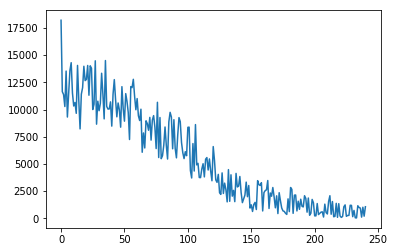

In [254]:
################## Github model (DO NOT EDIT)####################################

# from tensorflow.contrib import rnn
# from tensorflow.python.ops import variable_scope
# from tensorflow.python.framework import dtypes
# import tensorflow as tf
# import copy
# import os
# import matplotlib.pyplot as plt

# feats_used = ["day", "hourOfDay", "weekNum", "daysAfterPrevAssnDue", "daysUntilNextAssnDue", "daysTilExam", 
#                          "isFirstOHWithinLastThreeHour", "NumStudents", "InstructorRating", "AvgHrsSpent"]
# output_class = ["loadInflux"]

# def get_data(paths):
            
#     frames_X, frames_Y = [], []
#     for path in paths:
#         frames_X.append(pd.read_csv(path, usecols = feats_used))
#         frames_Y.append(pd.read_csv(path, usecols = output_class))
#     return (pd.concat(frames_X), pd.concat(frames_Y))
    
# def generate_train_samples(x, y, input_seq_len, output_seq_len, batch_size = 16):

#     total_start_points = len(x) - input_seq_len - output_seq_len
#     start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)

#     input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
#     input_seq = np.take(x, input_batch_idxs, axis = 0)

#     output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
#     output_seq = np.take(y, output_batch_idxs, axis = 0)

#     return (input_seq, output_seq) # in shape: (batch_size, time_steps, feature_dim)

# def generate_test_samples(x, y, input_seq_len, output_seq_len):

#     total_samples = x.shape[0]

#     input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
#     input_seq = np.take(x, input_batch_idxs, axis = 0)

#     output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
#     output_seq = np.take(y, output_batch_idxs, axis = 0)

#     return (input_seq, output_seq)

# train_ds = ["CS107Autumn2017dataset.csv", "CS107Autumn2018dataset.csv", "CS107Spring2017dataset.csv",
#             "CS107Spring2018dataset.csv"]
# dir_path = "DeepQueueLearning/Datasets/"
# train_paths, test_paths = [], []
# for ds in train_ds:
#     train_paths.append(dir_path + ds)
    
# X, Y = get_data(train_paths) #All train data in one series

# X_train, Y_train = X.values, Y.values

# ## Parameters
# learning_rate = 0.001
# lambda_l2_reg = 0.01  

# ## Network Parameters
# # length of input signals
# input_seq_len = 10
# # length of output signals
# output_seq_len = 1
# # size of LSTM Cell
# hidden_dim = 512
# # num of input signals
# input_dim = X_train.shape[1]
# # num of output signals
# output_dim = Y_train.shape[1]
# # num of stacked lstm layers 
# num_stacked_layers = 2 
# # gradient clipping - to avoid gradient exploding
# GRADIENT_CLIPPING = 2.5 

# total_iterations = 5000
# batch_size = 512

# def build_graph(feed_previous = False):
    
#     tf.reset_default_graph()
    
#     global_step = tf.Variable(
#                   initial_value=0,
#                   name="global_step",
#                   trainable=False,
#                   collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
#     weights = {
#         'out': tf.get_variable('Weights_out', \
#                                shape = [hidden_dim, output_dim], \
#                                dtype = tf.float32, \
#                                initializer = tf.truncated_normal_initializer()),
#     }
#     biases = {
#         'out': tf.get_variable('Biases_out', \
#                                shape = [output_dim], \
#                                dtype = tf.float32, \
#                                initializer = tf.constant_initializer(0.)),
#     }
                                          
#     with tf.variable_scope('Seq2seq'):
#         # Encoder: inputs
#         enc_inp = [
#             tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
#                for t in range(input_seq_len)
#         ]

#         # Decoder: target outputs
#         target_seq = [
#             tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
#               for t in range(output_seq_len)
#         ]

#         # Give a "GO" token to the decoder. 
#         # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
#         # first element will be fed as decoder input which is then 'un-guided'
#         dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

#         with tf.variable_scope('LSTMCell'): 
#             cells = []
#             for i in range(num_stacked_layers):
#                 with tf.variable_scope('RNN_{}'.format(i)):
#                     cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
#             cell = tf.contrib.rnn.MultiRNNCell(cells)
         
#         def _rnn_decoder(decoder_inputs,
#                         initial_state,
#                         cell,
#                         loop_function=None,
#                         scope=None):
          
#             with variable_scope.variable_scope(scope or "rnn_decoder"):
#                 state = initial_state
#                 outputs = []
#                 prev = None
#                 for i, inp in enumerate(decoder_inputs):
#                     if loop_function is not None and prev is not None:
#                         with variable_scope.variable_scope("loop_function", reuse=True):
#                             inp = loop_function(prev, i)
#                     if i > 0:
#                         variable_scope.get_variable_scope().reuse_variables()
#                     output, state = cell(inp, state)
#                     outputs.append(output)
#                     if loop_function is not None:
#                         prev = output

#             return outputs, state

#         def _basic_rnn_seq2seq(encoder_inputs,
#                               decoder_inputs,
#                               cell,
#                               feed_previous,
#                               dtype=dtypes.float32,
#                               scope=None):
            
#             with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
#                 enc_cell = copy.deepcopy(cell)
#                 _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
#                 if feed_previous:
#                     return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
#                 else:
#                     return _rnn_decoder(decoder_inputs, enc_state, cell)

#         def _loop_function(prev, _):
#             return tf.matmul(prev, weights['out']) + biases['out']
        
#         dec_outputs, dec_memory = _basic_rnn_seq2seq(
#             enc_inp, 
#             dec_inp, 
#             cell, 
#             feed_previous = feed_previous
#         )
# #         print(dec_outputs)
#         reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
#     # Training loss and optimizer
#     with tf.variable_scope('Loss'):
#         # L2 loss
#         output_loss = 0
#         for _y, _Y in zip(reshaped_outputs, target_seq):
#             output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

#         # L2 regularization for weights and biases
#         reg_loss = 0
#         for tf_var in tf.trainable_variables():
#             if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
#                 reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

#         loss = output_loss + lambda_l2_reg * reg_loss

#     with tf.variable_scope('Optimizer'):
#         optimizer = tf.contrib.layers.optimize_loss(
#                 loss=loss,
#                 learning_rate=learning_rate,
#                 global_step=global_step,
#                 optimizer='Adam',
#                 clip_gradients=GRADIENT_CLIPPING)
        
#     saver = tf.train.Saver
    
#     return dict(
#         enc_inp = enc_inp, 
#         target_seq = target_seq, 
#         train_op = optimizer, 
#         loss=loss,
#         saver = saver, 
#         reshaped_outputs = reshaped_outputs,
#         )

# train_losses = []
# val_losses = []

# rnn_model = build_graph(feed_previous=False)

# saver = tf.train.Saver()

# init = tf.global_variables_initializer()
# train_preds, train_targets = [], []
# with tf.Session() as sess:

#     sess.run(init)

#     try:
#         for i in range(total_iterations):
#             batch_input, batch_output = generate_train_samples(X_train, Y_train, input_seq_len, output_seq_len,
#                                                                batch_size=batch_size)
#             print(batch_input.shape)
#             feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
#             feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
#             _, loss_t, reshaped_outputs, target_seq = sess.run([rnn_model['train_op'], rnn_model['loss'],
#                                                            rnn_model['reshaped_outputs'], rnn_model['target_seq']],
#                                                           feed_dict)
#             print("Training iteration: {}, Loss: {}".format(i+1, loss_t))
# #             print(type(train_preds), type(target_seq))
#             if (i % 10 == 0) : 
#                 train_losses.append(loss_t)
#                 for i in range(len(target_seq)):
#                     train_preds.append(reshaped_outputs[i]) 
#                     train_targets.append(target_seq[i]) 
#     except KeyboardInterrupt:
#         print("Training interrupted.")
        
#     temp_saver = rnn_model['saver']()
#     save_path = temp_saver.save(sess, os.path.join('./saved_model/', 'multivariate_ts_pollution_case'))
#     plt.plot(train_losses) 
# print("Checkpoint saved at: ", save_path)